In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
import re

import collections
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import Model
from keras import Input
from keras import layers
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping,ModelCheckpoint

from tqdm import tqdm
import os, re, csv, math, codecs

In [3]:
#한글 깨짐 처리
import os

if os.name == 'posix':
    plt.rc("font", family="AppleGothic")

else :
    plt.rc("font", family="Malgun Gothic")

%config InlineBackend.figure_format = 'retina'

In [4]:
train = pd.read_csv("capstone_dataset/train.csv")
val = pd.read_csv("capstone_dataset/valid.csv")
test = pd.read_csv("capstone_dataset/test.csv")

In [5]:
def preprocessing(text):
    m = Mecab()
    
    cleaned_text = re.sub('[^가-힣]', ' ', text) #한글과 영어 소문자만 남기고 다른 글자 모두 제거
    tokenized_text = m.morphs(cleaned_text)
    removed_by_len_text = [token for token in tokenized_text if len(token)>1]
    return removed_by_len_text

In [6]:
train['title_token'] = train['title'].apply(preprocessing)
train['body_token'] = train['body'].apply(preprocessing)

val['title_token'] = val['title'].apply(preprocessing)
val['body_token'] = val['body'].apply(preprocessing)

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer() 
tokenized_text = pd.concat([train.body_token,train.title_token],axis=0)
tokenizer.fit_on_texts(tokenized_text)
vocab_size = len(tokenizer.word_index) + 1 # 패딩을 고려하여 +1

In [ ]:
def encoded_text(tokenizer,tokenized_data,max_len):
    encoded = tokenizer.texts_to_sequences(tokenized_data)
    padded = pad_sequences(encoded, maxlen=max_len)
    return padded

In [ ]:
train_encoded_title_text = encoded_text(tokenizer,train['title_token'],10)
train_encoded_body_text = encoded_text(tokenizer,train['body_token'],415)

val_encoded_title_text = encoded_text(tokenizer,val['title_token'],10)
val_encoded_body_text = encoded_text(tokenizer,val['body_token'],415)

# dataset만들기

In [109]:
processed_train = pd.DataFrame(list(zip(train_encoded_title_text,train_encoded_body_text,train.label.values)),columns =['train_encoded_title_text','train_encoded_body_text','y_train'])
processed_val = pd.DataFrame(list(zip(val_encoded_title_text,val_encoded_body_text, val.label.values)),columns=['val_encoded_title_text','val_encoded_body_text','y_val'])

In [111]:
df1 = pd.concat([train,processed_train],axis=1)
df2 = pd.concat([val,processed_val],axis=1)

In [116]:
df1 = df1.drop('y_train',axis=1)
df2 = df2.drop('y_val',axis=1)

In [118]:
df1.to_csv("capstone_dataset/processed_train.csv")
df2.to_csv("capstone_dataset/processed_val.csv")

In [119]:
train = pd.read_csv("capstone_dataset/processed_train.csv")
val = pd.read_csv("capstone_dataset/processed_val.csv")

In [120]:
tokenizer = Tokenizer() 
tokenized_text = pd.concat([train.body_token,train.title_token],axis=0)
tokenizer.fit_on_texts(tokenized_text)
vocab_size = len(tokenizer.word_index) + 1 # 패딩을 고려하여 +1

# word embedding - FastText

In [ ]:
import gensim
from gensim import models
from gensim.models import fasttext
from gensim.models import Word2Vec, KeyedVectors

In [ ]:
ft_model = fasttext.load_facebook_model('/Users/saeran/Desktop/SJU2022/캡스톤/fasttext_wiki.ko/wiki.ko.bin')
ft_model.build_vocab(sentences=tokenized_text, update=True)
ft_model.train(tokenized_text, total_examples=len(tokenized_text),epochs=5)

In [ ]:
ft_model.wv.vectors.shape

In [ ]:
ft_model.similar_by_word('병원')

In [ ]:
#pretrained+training fasttext embedding matrix
embedding_matrix = np.zeros((vocab_size, 300)) #200차원의 임베딩 매트릭스 생성
words_not_found = []

for word,index in tokenizer.word_index.items(): #vocabulary에 있는 토큰들을 하나씩 넘겨줍니다.
    if word in ft_model: #넘겨 받은 토큰이 word2vec에 존재하면(이미 훈련이 된 토큰이라는 뜻)
        embedding_vector = ft_model[word] #해당 토큰에 해당하는 vector를 불러오고
        embedding_matrix[index] = embedding_vector #해당 위치의 embedding_mxtrix에 저장합니다.
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

In [ ]:
len(tokenizer.word_index)

# model : CNN

In [ ]:
X_train_title, X_val_title = train.train_encoded_title_text, val.val_encoded_title_text
X_train_body, X_val_body = train.train_encoded_body_text, val.val_encoded_body_text
y_train, y_val = train.label.values, val.label.values

In [ ]:
X_train_title.shape, X_val_title.shape,X_train_body.shape,X_val_body.shape, y_train.shape, y_val.shape

In [132]:
#training params
batch_size = 256 
num_epochs = 8 

#model parameters
num_filters = 256
kernel_size = 3
weight_decay = 1e-4

In [4]:
#title 입력층
input_title = Input(shape=(10,),name="title",dtype='int32')
embedded_title = layers.Embedding(vocab_size, 300,weights = [embedding_matrix], input_length = 10,trainable=False)(input_title)
#body 입력층
input_body = Input(shape=(415,),name="body",dtype='int32')
embedded_body = layers.Embedding(vocab_size, 300,weights = [embedding_matrix], input_length = 415,trainable=False)(input_body)

#title + body
concatenated = layers.concatenate([embedded_title,embedded_body],axis=1) #430차원
dropout = Dropout(0.2)(concatenated)

#title + body
conv1 = Conv1D(num_filters, kernel_size=kernel_size, activation='relu', padding='same')(dropout)
pool1 = MaxPooling1D(2)(conv1)

conv2 = Conv1D(num_filters, kernel_size=kernel_size, activation='relu', padding='same')(pool1)
pool2 = MaxPooling1D(2)(conv2)

conv3 = Conv1D(num_filters, kernel_size=kernel_size, activation='relu', padding='same')(pool2)
pool3 = GlobalMaxPooling1D()(conv3)

dense = Dense(256,activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(pool3)
dropout = Dropout(0.2)(dense)
output = Dense(1, activation='sigmoid')(dropout)

model = Model(inputs=[input_title,input_body],outputs=output)

#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

NameError: name 'vocab_size' is not defined

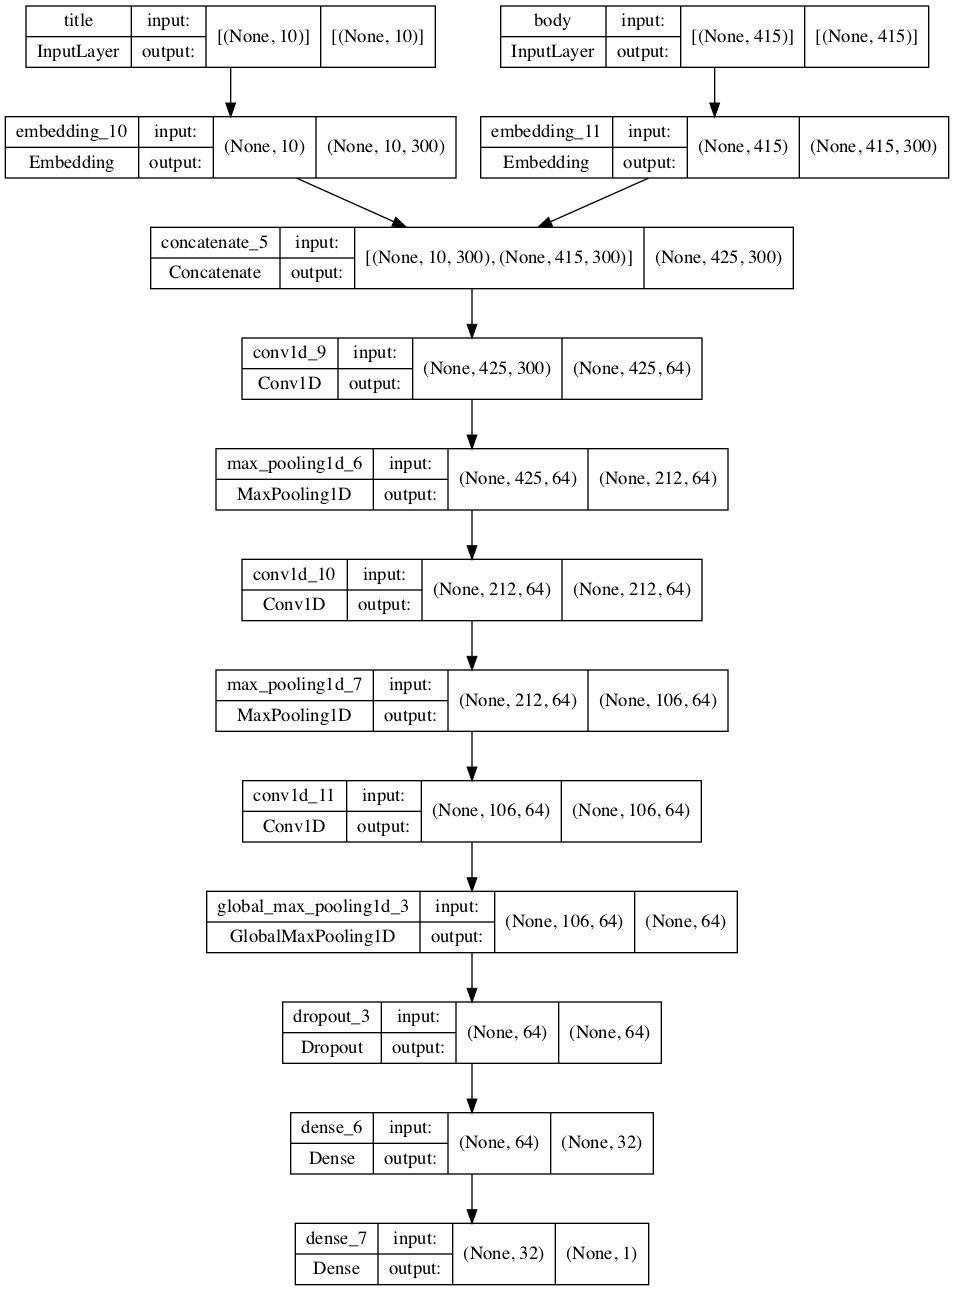

In [135]:
from tensorflow import keras
from tensorflow.keras.utils import plot_model
keras.utils.plot_model(model,show_shapes=True)

In [136]:
history = model.fit({'title':X_train_title,'body':X_train_body}, y_train, epochs=10, batch_size=256, verbose=1,callbacks=[es,mc],validation_data=[[X_val_title,X_val_body],y_val])

Epoch 1/10


ValueError: in user code:

    File "/Users/saeran/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/Users/saeran/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/saeran/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/Users/saeran/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/Users/saeran/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/saeran/opt/anaconda3/lib/python3.8/site-packages/keras/backend.py", line 6065, in pool2d
        x = tf.compat.v1.nn.max_pool(

    ValueError: Exception encountered when calling layer "max_pooling1d_7" (type MaxPooling1D).
    
    Negative dimension size caused by subtracting 2 from 1 for '{{node model_2/max_pooling1d_7/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 1, 1], padding="VALID", strides=[1, 2, 1, 1]](model_2/max_pooling1d_7/ExpandDims)' with input shapes: [?,1,1,64].
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 1, 64), dtype=float32)


In [ ]:
pd.DataFrame(history.history)

In [ ]:
#Diagnostic Plots
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
#Diagnostic Plots
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model train vs validation loss')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
#prediction = model.predict([X_val_title,X_val_body])
#result = val.copy() #깊은 복사
#result['prediction_CNN']=prediction 
#result.to_csv('result_실험제목.csv')